In [1]:
%load_ext autoreload
%autoreload 2
import os
import random

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import layers, optimizers, losses, metrics, callbacks, ops
from PIL import Image

2024-01-09 13:06:04.854412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/env_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
plt.style.use("seaborn-v0_8")

2024-01-09 13:06:07.676105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 13:06:07.700843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 13:06:07.701086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Classification with Oxford102

### Dataset

In [3]:
DATASET_PATH = "/mnt/dl/datasets/Oxford102FlowersSplits/"

In [4]:
LABELS = {i: k.strip() for i, k in enumerate(open(os.path.join(DATASET_PATH, "names.txt")))}

In [5]:
LABELS[0]

'pink primrose'

In [6]:
batch_size = 64
img_size = 224
SIZE = 1000000
batch_size = 32
num_classes = len(LABELS)
num_classes

102

In [7]:
def load_dataset(split):
    path = os.path.join(DATASET_PATH, split, )
    img_files = os.listdir(os.path.join(path, "jpeg"))
    img_files = sorted(img_files, key=lambda x: int(x.replace(".jpeg", "")))
    img_files = list(img_files)[:SIZE]
    
    labels = list(open(os.path.join(path, "label", "label.txt"),))
    labels = [int(l.strip()) for l in labels][:SIZE]
    
    img_files = [np.array(Image.open(os.path.join(path, "jpeg", name)).resize((224, 224))).astype(np.uint8) 
                 for name in img_files]
    
    img_ds = tf.data.Dataset.from_tensor_slices(img_files)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((img_ds, label_ds))
    return ds

In [8]:
train_ds = load_dataset("train")
validation_ds = load_dataset("validation")
test_ds = load_dataset("test")

2024-01-08 17:15:28.984150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 17:15:28.984393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 17:15:28.984551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
aug_layers = [layers.RandomRotation(0.1), layers.RandomFlip()]

def preprocess(img, label, training):
    if training:
        for aug in aug_layers:
            img = aug(img)
    return tf.cast(img, tf.float32), label
    
train_ds = train_ds.map(lambda img, label: preprocess(img, label, training=True), num_parallel_calls=5).batch(batch_size)
validation_ds = validation_ds.map(lambda img, label: preprocess(img, label, training=False), num_parallel_calls=5).batch(batch_size)
test_ds = test_ds.map(lambda img, label: preprocess(img, label, training=False), num_parallel_calls=5).batch(batch_size)

### MiniResnet

In [10]:


def block(x, filters, blocks=2, stride=1, name="conv"):
    prev_x = x
    
    for i in range(1, blocks+1):
        x = layers.Conv2D(filters, 3, strides=(stride if i == 1 else 1), padding="SAME", 
                          name=f"{name}_b{i}1")(prev_x)
        
        x = layers.BatchNormalization(name=f"bn_{name}_b{i}1")(x)
        x = ops.nn.relu(x)
        
        x =  layers.Conv2D(filters, 3, padding="SAME", name=f"{name}_b{i}2")(x)
        x = layers.BatchNormalization()(x)
        
        if stride == 2 and i == 1:
            prev_x = layers.Conv2D(filters, 1, strides=2, use_bias=False)(prev_x)
            prev_x = layers.BatchNormalization()(prev_x)
            
        x = layers.add([x, prev_x])
        prev_x =  layers.Activation("relu", name=f"{name}_b{i}out")(x)
    
    return prev_x


def mlp(x, units):
    for i in range(len(units) - 1):
        x = layers.Dense(units[i], activation=keras.activations.relu)(x)
        x = layers.Dropout(0.1)(x)
    return layers.Dense(units[-1])(x)


def mini_resnet():
    input = keras.Input(shape=(224, 224, 3))
    x = layers.Rescaling(1/255.)(input)
    
    x = layers.Conv2D(64, 7, padding="SAME", strides=2, name="conv1")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(keras.activations.relu)(x)
    
    x = layers.MaxPool2D()(x)
    
    x = block(x, 64, 2, name="conv2")
    x = block(x, 128, 2, 2, name="conv3")
    x = block(x, 256, 2, 2, name="conv4")
    x = block(x, 512, 2, 2, name="conv5")
    
    x = layers.GlobalAveragePooling2D()(x)
    x = mlp(x, [1024, num_classes])
    model = keras.Model(inputs=input, outputs=x)
    return model


In [11]:
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [12]:
model = mini_resnet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ rescaling           │ (None, 224, 224,  │       0 │ input_layer[0][0]    │
│ (Rescaling)         │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1 (Conv2D)      │ (None, 112, 112,  │   9,472 │ rescaling[0][0]      │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 112, 112,  │     256 │ conv1[0][0]          │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation          │ (None, 112, 112,  │       0 │ batch_normalization… │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │       0 │ activation[0][0]     │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_b11 (Conv2D)  │ (None, 56, 56,    │  36,928 │ max_pooling2d[0][0]  │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bn_conv2_b11        │ (None, 56, 56,    │     256 │ conv2_b11[0][0]      │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ relu (Relu)         │ (None, 56, 56,    │       0 │ bn_conv2_b11[0][0]   │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_b12 (Conv2D)  │ (None, 56, 56,    │  36,928 │ relu[0][0]           │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │     256 │ conv2_b12[0][0]      │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add (Add)           │ (None, 56, 56,    │       0 │ batch_normalization… │
│                     │ 64)               │         │ max_pooling2d[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_b1out         │ (None, 56, 56,    │       0 │ add[0][0]            │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_b21 (Conv2D)  │ (None, 56, 56,    │  36,928 │ conv2_b1out[0][0]    │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bn_conv2_b21        │ (None, 56, 56,    │     256 │ conv2_b21[0][0]      │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ relu_1 (Relu)       │ (None, 56, 56,    │       0 │ bn_conv2_b21[0][0]   │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_b22 (Conv2D)  │ (None, 56, 56,    │  36,928 │ relu_1[0][0]       

 Total params: 11,819,878 (45.09 MB)

 Trainable params: 11,810,278 (45.05 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [13]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy("acc")]
              )

In [14]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=100, )

Epoch 1/100


2024-01-08 17:24:14.687513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [1020,224,224,3]
	 [[{{node Placeholder/_0}}]]
2024-01-08 17:24:22.500679: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x5646a316f280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-08 17:24:22.500751: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA TITAN RTX, Compute Capability 7.5
2024-01-08 17:24:22.736331: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-08 17:24:24.419368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
202

 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - acc: 0.0226 - loss: 5.0656

2024-01-08 17:24:33.350928: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - acc: 0.0141 - loss: 5.0961

2024-01-08 17:24:45.422499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [1020]
	 [[{{node Placeholder/_2}}]]


32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 476ms/step - acc: 0.0140 - loss: 5.0899 - val_acc: 0.0098 - val_loss: 741.8025
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - acc: 0.0232 - loss: 4.4804 - val_acc: 0.0098 - val_loss: 22.6831
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - acc: 0.0468 - loss: 4.1206 - val_acc: 0.0157 - val_loss: 16.1884
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - acc: 0.0833 - loss: 3.8285 - val_acc: 0.0157 - val_loss: 14.9451
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - acc: 0.0819 - loss: 3.6829 - val_acc: 0.0118 - val_loss: 10.7713
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - acc: 0.1103 - loss: 3.5212 - val_acc: 0.0069 - val_loss: 10.4417
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - acc: 0.1146 - loss: 3.4617 - val_acc: 0.0098 - val_loss: 6.8581
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - acc: 0.1325 - loss: 3.2999 - val_acc: 0.0431 - val_loss: 5.7584
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - acc: 

In [15]:
history.history.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])

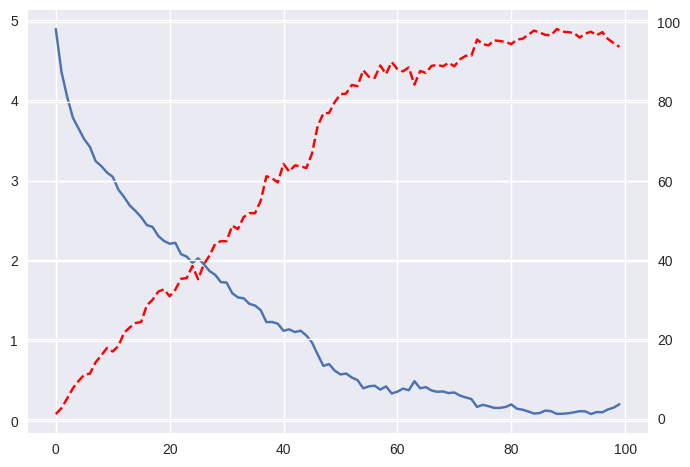

In [16]:
fig = plt.figure()
ax = plt.subplot(111)
ax2 = ax.twinx()
ax.plot(history.history["loss"])
ax2.plot(np.array(history.history['acc']) * 100., "r--")

In [ ]:
import gc

keras.backend.clear_session()
del model
gc.collect()


In [22]:
gc.collect()

16

### SENET (Squeeze & Excitation Networks)

In [288]:
class SqueezeExcitation(layers.Layer):
    
    def __init__(self, filters, ratio, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.ratio = ratio
        self.net = keras.Sequential()
        self.net.add(layers.GlobalAveragePooling2D(keepdims=True))
        self.net.add(layers.Conv2D(self.filters // self.ratio, 1, padding="SAME", activation="relu"))
        self.net.add(layers.Conv2D(self.filters, 1, padding="SAME", activation="sigmoid"))

    def call(self, x):
        scale = self.net(x)
        scaled_x = ops.multiply(x, scale)
        return scaled_x
    
    

class BlockSE(layers.Layer):
    
    def __init__(self, num_blocks, filters, ratio, stride, activation, **kwargs):
        super().__init__(**kwargs)
        self.num_blocks = num_blocks
        self.filters = filters
        self.ratio = ratio
        self.stride = stride
        self.activation = activation
        
    
    def build(self, input_shape):
        self.conv1 = layers.Conv2D(self.filters, 3, self.stride, padding="SAME")
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.Activation(self.activation)
        
        self.conv2 = layers.Conv2D(self.filters, 3, 1, padding="SAME")
        self.bn2 = layers.BatchNormalization()
        
        if self.stride > 1:
            self.down_conv = layers.Conv2D(self.filters, 1, strides=2, padding="SAME", use_bias=False)
            self.down_bn = layers.BatchNormalization()
        self.act2 = layers.Activation(self.activation)
        self.residual = layers.Lambda(lambda x: layers.add(x))
        
        self.se = SqueezeExcitation(self.filters, self.ratio)
        
    def call(self, x):
        prev_x = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        x = self.se(x)
        
        if self.stride > 1:
            prev_x = self.down_conv(prev_x)
            prev_x = self.down_bn(prev_x)
        x = self.residual([prev_x, x])
        
        x = self.act2(x)
        return x
                
        
        
class ResidualBlockSE(layers.Layer):
    
    def __init__(self, num_blocks, filters, ratio, stride, activation, **kwargs):
        super().__init__(**kwargs)
        self.num_blocks = num_blocks
        self.filters = filters
        self.ratio = ratio
        self.stride = stride
        self.activation = activation
    
    def build(self, input_shape):
        self.res_blocks = keras.Sequential()
        self.res_blocks.add(BlockSE(self.num_blocks, self.filters, self.ratio,
                                    self.stride, self.activation))
        for _ in range(1, self.num_blocks):
            self.res_blocks.add(BlockSE(self.num_blocks, self.filters, self.ratio,
                                    1, self.activation))
    
    def call(self, x):
        x = self.res_blocks(x)
        return x


class Classifier(layers.Layer):
    
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
    
    def build(self, input_shape):
        self.net = keras.Sequential()
        self.net.add(layers.GlobalAveragePooling2D())
        for i in range(len(self.units) - 1):
            self.net.add(layers.Dense(self.units[i], activation="relu"))
            self.net.add(layers.Dropout(0.1))
        self.net.add(layers.Dense(self.units[-1]))
        
    def call(self, x):
        return self.net(x)


# class SENet(keras.Layer):
class SENet(keras.Model):
    
    def __init__(self, name="senet", **kwargs):
        super(SENet, self).__init__(**kwargs)
        
        self.rescale = layers.Rescaling(1/255.)
        
    
        self.conv1 = layers.Conv2D(64, 7, strides=2, padding="SAME", name="senet_conv1")
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.Activation("gelu")
        
        self.pool1 = layers.MaxPool2D(3, 2)
        
        self.res_block1 = ResidualBlockSE(2, 64, ratio=16, activation="gelu", stride=1)
        self.res_block2 = ResidualBlockSE(2, 128, ratio=16, activation="gelu", stride=2)
        self.res_block3 = ResidualBlockSE(2, 256, ratio=16, activation="gelu", stride=2)
        self.res_block4 = ResidualBlockSE(2, 512, ratio=16, activation="gelu", stride=2)
        
        self.classifier = Classifier([1024, num_classes])
        
    def call(self, x):
        x = self.rescale(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = self.pool1(x)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        
        x  = self.classifier(x)
        
        return x
        


In [289]:
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

# input = keras.Input((224, 224, 3))
# net = SENet()
# model = keras.Model(input, net(input))
model = SENet()
# model(next(iter(train_ds))[0], training=False)

In [290]:
model.summary()

Model: "se_net_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ senet_conv1 (Conv2D)            │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_579         │ ?                         │          0 │
│ (BatchNormalization)            │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_481 (Activation)     │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ residual_block_se_153           │ ?                         │          0 │
│ (ResidualBlockSE)               │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ residual_block_se_154           │ ?                         │          0 │
│ (ResidualBlockSE)               │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ residual_block_se_155           │ ?                         │          0 │
│ (ResidualBlockSE)               │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ residual_block_se_156           │ ?                         │          0 │
│ (ResidualBlockSE)               │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ classifier_33 (Classifier)      │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [291]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy("acc")]
              )

In [295]:
history = model.fit(train_ds, epochs=30, validation_data=validation_ds)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - acc: 0.5215 - loss: 1.4915 - val_acc: 0.1225 - val_loss: 5.8257
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - acc: 0.5151 - loss: 1.5829 - val_acc: 0.1196 - val_loss: 6.0411
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - acc: 0.4727 - loss: 1.7242 - val_acc: 0.1363 - val_loss: 5.4309
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - acc: 0.5591 - loss: 1.5219 - val_acc: 0.1176 - val_loss: 5.6377
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - acc: 0.4896 - loss: 1.6940 - val_acc: 0.1147 - val_loss: 5.4838
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - acc: 0.4986 - loss: 1.6918 - val_acc: 0.1275 - val_loss: 5.4867
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - acc: 0.4779 - loss: 1.7788 - val_acc: 0.1520 - val_loss: 5.0465
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - acc: 0.5567 - loss: 1.4091 - val_acc: 0.1598 - val_loss: 5.4059
Epoch 9/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - acc: 0.6367